# Verifying generalizability


In [1]:
%cd /home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1

/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1


In [2]:
from src.util import read_results, train_test_validate_split, eval_result, eval_sota_models
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
plt.style.use("/home/pepijn/Documents/uni/y5/thesis/writing/msc-thesis-figures/std-colors.mplstyle")

%load_ext autoreload
%autoreload 2

In [3]:
result_df = read_results()
_, test, validate = train_test_validate_split(read_results())

train set:
	Records: 210953
	Positive (speedup > 1 with factorizing)/Negative: 39648/171305 = 0.23 s
	Dataset types: ['synthetic' 'hamlet']
\Compute Units: ['v100' 'CPU 08c' 'p100' 'CPU 16c' '1080' 'CPU 32c' '2080' 'a40']
test set:
	Records: 90409
	Positive (speedup > 1 with factorizing)/Negative: 16772/73637 = 0.23 s
	Dataset types: ['synthetic' 'hamlet']
\Compute Units: ['CPU 32c' '2080' 'CPU 16c' '1080' 'CPU 08c' 'v100' 'p100' 'a40']
validate set:
	Records: 11187
	Positive (speedup > 1 with factorizing)/Negative: 1123/10064 = 0.11 s
	Dataset types: ['synthetic' 'hamlet' 'tpc_ai']
\Compute Units: ['p100' 'CPU 32c' 'CPU 16c' 'CPU 08c' '2080' '1080' 'v100' 'a40']


In [4]:
rdf = result_df.loc[validate.index]
rdf[(rdf.dataset_type == 'synthetic') & (rdf.compute_unit != 'p100')]

,dataset,speedup,operator,num_cores,selectivity,cardinality_T,cardinality_S,join,compute_unit,complexity_ratio,...,gpu_clock_speed_max_boost,gpu_memory_bus_width,gpu_memory_size,gpu_memory_clock,gpu_memory_bandwidth,gpu_processing_power_half_precision,gpu_processing_power_single_precision,gpu_processing_power_double_precision,materialized_times_mean,time_saved


In [5]:

results = {}

file_to_name = {
    "STAT1_label.csv": "Statistical",
    # "STAT5_label.csv": "STAT.5",
    # "XGB3_label.csv": "XGB.3",
    "XGB5_label.csv": "XGBoost",
    "analytical1_label.csv": "Analytical",
    # "analytical2_label.csv": "Analytical.2",
    
}
for eval_type in ["new hardware", "real datasets", "full"]:
    val_df = result_df.loc[validate.index]
    if eval_type == "full":
        loc = val_df.index
    elif eval_type == "new hardware":
        loc = val_df[val_df.compute_unit == 'p100'].index
    else:
        loc = val_df[val_df.dataset_type != 'synthetic'].index
    y_true = validate.label.loc[loc]
    full_dataset = validate.loc[loc]
    
    results.update({(name, eval_type): val for (name, val) in eval_sota_models(full_dataset, y_true, full_dataset).items()})
    
    for f in glob.glob("evaluation/predictions/*_label.csv"):
        if f.split('/')[-1] in file_to_name.keys():
            df = pd.read_csv(f, index_col= 0)
            assert len(validate.index) == len(set(validate.index).intersection(df.index))
            print([col for col in df.columns if 'y_pred' in col])
            y_pred = df[[col for col in df.columns if 'y_pred' in col][0]]
            name = file_to_name[f.split('/')[-1]]
            results[(name, eval_type)] = eval_result(y_true, y_pred.loc[loc], target_col='label', full_dataset=full_dataset)[0]
        else:
            print(f"Skipping {f}")
results.keys()

2024-03-28 13:22:59.166 | INFO     | src.util:eval_model:482 - Model <class 'src.estimators.MorpheusFI'>, MorpheusFI
 test cols: Index(['speedup', 'operator', 'num_cores', 'selectivity', 'cardinality_T',
       'cardinality_S', 'join', 'complexity_ratio', 'times_mean',
       'compute_type', 'label', 'parallelism', 'mem_mat_read', 'mem_mat_write',
       'mem_fac_read', 'mem_fac_write', 'comp_scalar_mat', 'comp_lmm_mat',
       'comp_rmm_mat', 'comp_scalar_fac', 'comp_lmm_fac', 'comp_rmm_fac',
       'comp_mat_col_major', 'comp_fac_col_major', 'comp_scalar_dense', '13',
       '14', 'comp_matrix_dense', 'mem_read_scalar_dense',
       'mem_write_scalar_dense', 'mem_read_matrix_dense',
       'mem_write_matrix_dense', 'mem_read_rowsum', 'mem_write_rowsum',
       'mem_read_colsum', 'mem_write_colsum', '24', '25', 'comp_rowsum',
       'comp_colsum', 'comp_mat', 'comp_fac', 'comp_ratio', 'tr', 'fr', 'r_S',
       'c_S', 'TR', 'FR', 'nnz_T', 'nnz_S_sum', 'nnz_S', 'r_T', 'c_T',
       'spa

2024-03-28 13:22:59.421 | INFO     | src.util:eval_model:482 - Model <class 'src.estimators.MorpheusFI'>, MorpheusFI
 test cols: Index(['speedup', 'operator', 'num_cores', 'selectivity', 'cardinality_T',
       'cardinality_S', 'join', 'complexity_ratio', 'times_mean',
       'compute_type', 'label', 'parallelism', 'mem_mat_read', 'mem_mat_write',
       'mem_fac_read', 'mem_fac_write', 'comp_scalar_mat', 'comp_lmm_mat',
       'comp_rmm_mat', 'comp_scalar_fac', 'comp_lmm_fac', 'comp_rmm_fac',
       'comp_mat_col_major', 'comp_fac_col_major', 'comp_scalar_dense', '13',
       '14', 'comp_matrix_dense', 'mem_read_scalar_dense',
       'mem_write_scalar_dense', 'mem_read_matrix_dense',
       'mem_write_matrix_dense', 'mem_read_rowsum', 'mem_write_rowsum',
       'mem_read_colsum', 'mem_write_colsum', '24', '25', 'comp_rowsum',
       'comp_colsum', 'comp_mat', 'comp_fac', 'comp_ratio', 'tr', 'fr', 'r_S',
       'c_S', 'TR', 'FR', 'nnz_T', 'nnz_S_sum', 'nnz_S', 'r_T', 'c_T',
       'spa

['stat_y_pred']
['xgb_y_pred_time_saved']
Skipping evaluation/predictions/XGB3_label.csv
['analytical_y_pred']
Skipping evaluation/predictions/analytical2_label.csv
Skipping evaluation/predictions/STAT5_label.csv
['stat_y_pred']
['xgb_y_pred_time_saved']
Skipping evaluation/predictions/XGB3_label.csv


2024-03-28 13:22:59.563 | INFO     | src.util:eval_model:482 - Model <class 'src.estimators.MorpheusFI'>, MorpheusFI
 test cols: Index(['speedup', 'operator', 'num_cores', 'selectivity', 'cardinality_T',
       'cardinality_S', 'join', 'complexity_ratio', 'times_mean',
       'compute_type', 'label', 'parallelism', 'mem_mat_read', 'mem_mat_write',
       'mem_fac_read', 'mem_fac_write', 'comp_scalar_mat', 'comp_lmm_mat',
       'comp_rmm_mat', 'comp_scalar_fac', 'comp_lmm_fac', 'comp_rmm_fac',
       'comp_mat_col_major', 'comp_fac_col_major', 'comp_scalar_dense', '13',
       '14', 'comp_matrix_dense', 'mem_read_scalar_dense',
       'mem_write_scalar_dense', 'mem_read_matrix_dense',
       'mem_write_matrix_dense', 'mem_read_rowsum', 'mem_write_rowsum',
       'mem_read_colsum', 'mem_write_colsum', '24', '25', 'comp_rowsum',
       'comp_colsum', 'comp_mat', 'comp_fac', 'comp_ratio', 'tr', 'fr', 'r_S',
       'c_S', 'TR', 'FR', 'nnz_T', 'nnz_S_sum', 'nnz_S', 'r_T', 'c_T',
       'spa

['analytical_y_pred']
Skipping evaluation/predictions/analytical2_label.csv
Skipping evaluation/predictions/STAT5_label.csv
['stat_y_pred']
['xgb_y_pred_time_saved']
Skipping evaluation/predictions/XGB3_label.csv
['analytical_y_pred']
Skipping evaluation/predictions/analytical2_label.csv
Skipping evaluation/predictions/STAT5_label.csv


dict_keys([('MorpheusFI', 'new hardware'), ('Morpheus', 'new hardware'), ('Amalur', 'new hardware'), ('Statistical', 'new hardware'), ('XGBoost', 'new hardware'), ('Analytical', 'new hardware'), ('MorpheusFI', 'real datasets'), ('Morpheus', 'real datasets'), ('Amalur', 'real datasets'), ('Statistical', 'real datasets'), ('XGBoost', 'real datasets'), ('Analytical', 'real datasets'), ('MorpheusFI', 'full'), ('Morpheus', 'full'), ('Amalur', 'full'), ('Statistical', 'full'), ('XGBoost', 'full'), ('Analytical', 'full')])

In [6]:
eval_results = pd.DataFrame(results).T
merged_results = (
    eval_results.reset_index(names=["model", "eval_type"])
    .merge(pd.json_normalize(eval_results.speedup), left_index=True, right_index=True)
    .drop(columns="speedup")
).sort_values(['model', 'eval_type'])
merged_results['fraction_of_optimal_performance'] =  merged_results.y_pred_time_saved / merged_results.y_true_time_saved
merged_results['model_type'] = merged_results.model.apply(lambda x: x in ['Amalur', 'Morpheus', 'MorpheusFI']).map({True: 'SOTA', False: 'own'})
merged_results

,model,eval_type,accuracy,precision,recall,f1,y_true_mat_time,y_true_fact_time,y_true_best_time,y_true_time_saved,...,y_pred_best_time,y_pred_time_saved,y_pred_speedup_avg,y_pred_speedup_real,TP,FP,TN,FN,fraction_of_optimal_performance,model_type
14,Amalur,full,0.743363,0.128401,0.268923,0.173813,2792.661281,1125.213199,1125.213199,1667.448082,...,1191.483038,-507.350463,0.894552,0.762470,"(302, 3.4123536322426986)","(2050, 0.5236365896605994)","(8014, 0.3389793863528731)","(821, 4.2392536973143775)",-0.304268,SOTA
2,Amalur,new hardware,0.752671,0.043155,0.147708,0.066795,1408.911454,472.685621,472.685621,936.225833,...,893.265095,-676.176203,0.610594,0.603862,"(87, 2.584206354159701)","(1929, 0.521581512806116)","(7311, 0.31236672296037205)","(502, 3.4546332294332616)",-0.722236,SOTA
8,Amalur,real datasets,0.652914,0.671875,0.389728,0.493308,1895.431467,804.295675,804.295675,1091.135792,...,332.248282,301.676473,2.721876,1.651230,"(258, 3.7724723263290647)","(126, 0.5706541747294778)","(739, 0.6215475166453209)","(404, 5.881286444626252)",0.276479,SOTA
17,Analytical,full,0.906946,0.606771,0.20748,0.309224,2792.661281,1125.213199,1125.213199,1667.448082,...,353.967989,257.373986,2.549376,1.475877,"(233, 3.817285763945922)","(151, 0.5929317525189978)","(9913, 0.37329800427779536)","(890, 4.069135392621347)",0.154352,own
5,Analytical,new hardware,0.944348,0.9375,0.076401,0.141287,1408.911454,472.685621,472.685621,936.225833,...,39.390457,141.671058,3.430069,4.591778,"(45, 3.598085867443229)","(3, 0.9098199829695063)","(9237, 0.35586385079759325)","(544, 3.3035624447655256)",0.151321,own
11,Analytical,real datasets,0.62017,0.606771,0.351964,0.445507,1895.431467,804.295675,804.295675,1091.135792,...,353.967989,257.373986,2.549376,1.475877,"(233, 3.817285763945922)","(151, 0.5929317525189978)","(714, 0.6186181319137782)","(429, 5.7340559459732034)",0.235877,own
13,Morpheus,full,0.308572,0.065457,0.443455,0.114076,2792.661281,1125.213199,1125.213199,1667.448082,...,3216.534526,-6708.354153,0.505625,0.365334,"(498, 2.5668388611834354)","(7110, 0.3612535256520043)","(2954, 0.4135149775390669)","(625, 5.172275727300877)",-4.023126,SOTA
1,Morpheus,new hardware,0.267169,0.050435,0.629881,0.093392,1408.911454,472.685621,472.685621,936.225833,...,2884.934398,-6679.622045,0.451173,0.330814,"(371, 2.2116919019551227)","(6985, 0.35766509810511227)","(2255, 0.35102134789448713)","(218, 5.222541919091931)",-7.134627,SOTA
7,Morpheus,real datasets,0.588736,0.559028,0.243202,0.338947,1895.431467,804.295675,804.295675,1091.135792,...,369.821568,92.929285,2.256180,1.148341,"(161, 3.5884141741026476)","(127, 0.5672856408388691)","(738, 0.6221961577645935)","(501, 5.532141520541672)",0.085167,SOTA
12,MorpheusFI,full,0.09806,0.095753,0.945681,0.173899,2792.661281,1125.213199,1125.213199,1667.448082,...,11402.449098,-13733.249023,0.732680,0.486830,"(1062, 4.098247872408921)","(10029, 0.3762900677889165)","(35, 0.4635063194603)","(61, 2.6003088841659823)",-8.236088,SOTA


In [7]:
# test_set_fraction_of_optimal_performance = pd.Series({
#     "XGB.3": 0.956145,
#     "XGB.5": 0.929038,
#     "STAT.1": 0.39195,
#     "STAT.5": 0.301950,
#     "Analytical.1": 0.18,
#     "Analytical.2": 0.0117,
# })

test_set_fraction_of_optimal_performance = pd.Series({
    "XGBoost": 0.929038,
    "Statistical": 0.39195,
    "Analytical": 0.18,
})
merged_results['test_set_fraction_of_optimal_performance'] = merged_results.model.map(test_set_fraction_of_optimal_performance)
merged_results['performance_pct_vs_baseline'] = merged_results.fraction_of_optimal_performance / merged_results.test_set_fraction_of_optimal_performance * 100

## New (real) datasets
Show performance loss

In [9]:
palette= sns.color_palette("rocket", len(merged_results.model.unique()))

/tmp/ipykernel_219764/1167986971.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["New hardware", "Real datasets", "Full test set"])


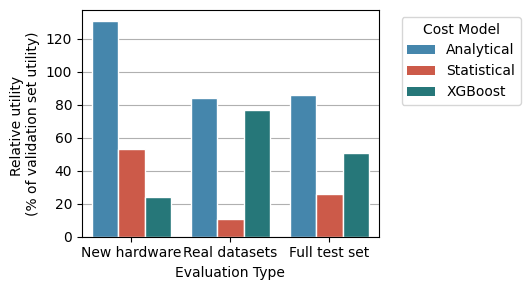

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(0.8 * 8, 3))
plotdf = merged_results[merged_results.model_type == "own"].sort_values("eval_type", ascending=False)
sns.barplot(data=plotdf, y="performance_pct_vs_baseline", x="eval_type", hue="model", ax=ax, )
ax.grid(axis="y")
ax.set_axisbelow(True)
# ax.set_ylim(0., 1.)
ax.legend(title="Cost Model", ncol=1, loc="upper right", bbox_to_anchor=(1.5, 1.0))
ax.set_ylabel("Relative utility \n(% of validation set utility)")
ax.set_xlabel("Evaluation Type")
ax.set_xticklabels(["New hardware", "Real datasets", "Full test set"])

for patch in ax.patches:
    patch.set_edgecolor("white")
    # if patch.get_height() < 0.1:
    #     ax.annotate(
    #         f"{patch.get_height():.2f}",
    #         (patch.get_x() + patch.get_width() / 2.0, patch.get_height()),
    #         ha="center",
    #         va="center",
    #         xytext=(0, 10),
    #         textcoords="offset points",
    #         fontsize=8,
    #         color="black",
    #         rotation=0,
    #     )
fig.tight_layout()
fig.savefig("/home/pepijn/Documents/uni/y5/thesis/writing/overleaf/chapters/06_evaluation/figures/eval_generalization.pdf", bbox_inches="tight")

## SOTA comparison

/tmp/ipykernel_219764/3438510286.py:15: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  ax = sns.barplot(
/tmp/ipykernel_219764/3438510286.py:15: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  ax = sns.barplot(
/tmp/ipykernel_219764/3438510286.py:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_right.set_xticklabels(labels=[None])


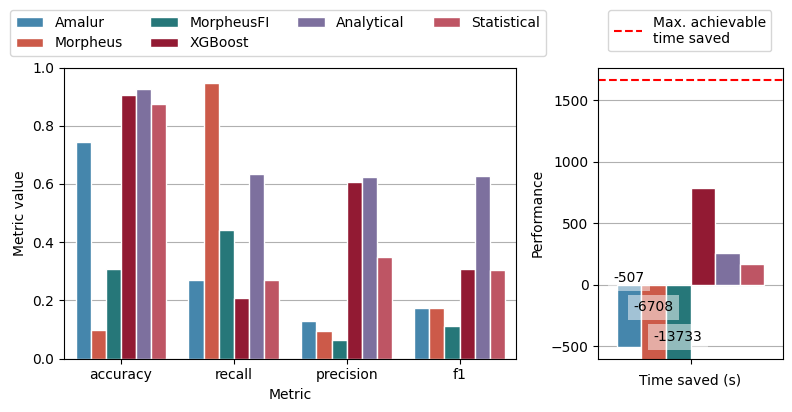

In [17]:
# colors = []
# for c in sns.color_palette("rocket_r", 6):
#     colors.extend([
#                    sns.set_hls_values(c, l=0.4),
#                    c])
# colors.pop(1)

fig, axs = plt.subplot_mosaic("AAB", figsize=(8, 3.7))
melted_df = pd.melt(merged_results, id_vars=["model", "eval_type", 'model_type'], var_name="metric", value_name="metric_value").sort_values("model_type")
max_time_saved = merged_results.y_true_time_saved.max()
min_ylim = -600
def plot_metrics(ax, metrics: list, legend=True):
    ax.set_axisbelow(True)
    ax.grid(axis="y")
    ax = sns.barplot(
        data=melted_df[(melted_df.metric.apply(lambda x: x in metrics)) & (melted_df.eval_type=='full')],
        x="metric",
        y="metric_value",
        hue="model",
        palette=sns.color_palette(n_colors=10),
        ax=ax,
    )
    if not legend:
        ax.get_legend().remove()
    else:
        legend = ax.legend(loc="upper center", bbox_to_anchor=(1.0, 1.1), ncol=5, borderaxespad=-1)
    # Add metric values as text on top of every bar
    for i, p in enumerate(ax.patches):
        p.set_edgecolor("white")
        fmt = ".2f" if abs(p.get_height()) < 1 else ".0f"
        height = p.get_height()
        if height <( min_ylim+100):
            ax.annotate(
                format(p.get_height(),fmt),
                (p.get_x() + p.get_width() / 2.0, 120*i*-2),
                ha="center",
                va="center",
                xytext=(0, 5),
                textcoords="offset points",
                bbox={"facecolor": "white", "alpha": 0.5, "edgecolor": "none"},
            )
    return legend

ax_left = axs["A"]
ax_right = axs["B"]
plot_metrics(ax_left, ["accuracy", "precision", "recall", "f1"], legend=False)
plot_metrics(ax_right, ["y_pred_time_saved"], legend=True)

ax_left.set_xlabel("Metric")
ax_left.set_ylabel("Metric value" )
ax_left.set_ylim(0., 1.)

ax_right.axhline(max_time_saved, ls="--", color="red", label="Max. achievable\ntime saved",)
ax_right.set_ylim(min_ylim, max_time_saved+100)
ax_right.set_xlabel("Time saved (s)")
ax_right.set_ylabel("Performance")
ax_right.set_xticklabels(labels=[None])

handles, labels = ax_right.get_legend_handles_labels()
l1 = fig.legend(handles[:-1], labels[:-1], ncols=4, loc="upper center", bbox_to_anchor=(0.35, 1.1), borderaxespad=0)
ax_right.legend().remove()
l2 = fig.legend([handles[-1]], [labels[-1]], loc="upper center", bbox_to_anchor=(0.865, 1.1), borderaxespad=0)

fig.tight_layout()
fig.savefig("/home/pepijn/Documents/uni/y5/thesis/writing/overleaf/chapters/06_evaluation/figures/eval_sota_results.pdf", bbox_inches="tight")